# Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import glob
import datetime
import time
import copy

import sys  
sys.path.insert(0, '../')

from soundings.preprocessing import dataloader as dl
from soundings.preprocessing import goesimager as im
from soundings.preprocessing import rtmaloader
from soundings.preprocessing import raploader
from soundings.preprocessing import preprocess
from soundings.utils import radiosonde_products
from soundings.utils import radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress
from metpy.plots import SkewT

np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# vol = '/Users/stock/Development/research/soundings/data/subset/'
vol = '/mnt/mlnas01/mlsoundings/'

GOES-16, NWP RAP/HRRR, RTMA, Radiosonde
---

- Radiosonde
    - Date
    - Latitude/Longitude
    - Elevation
    
- RTMA
    - Regional surface values Pressure/Temperature/Dew Point

- NWP
    - Regional model with isobaric values
        - v/u wind component
        - cloud ice
        - temperature
        - dew point
        - specific humidity
        
- GOES-16
    - Regional model capturing bands 8, 9, 10, 11, 13, 14, 15, 16

In [3]:
def add_input(D, inputs, key):
    x_cord, y_cord = dl.lat_lon_point(D, inputs['lat'], inputs['lon'])
    try:
        inputs[key] = D['data'][x_cord][y_cord]
    except:
        print(f'ERROR! Unable to extract value from {f}')
        
def error_msg(model, inputs):
    print(f'ERROR! Unable to get {model} data for sounding. '
          f"{inputs['date']}, {inputs['lat']}, {inputs['lon']}")

In [4]:
fin = vol + '/radiosonde/20190912.dat'
radiosondes = dl.read_sonde(fin)

interval = 5
ret = None

for i in range(len(radiosondes)):
    
    y = []
    x = []
    
    ## extract SOUNDINGS
    sonde = pd.DataFrame(radiosondes[i]['data']).values
    # interpolate sounding values 
    for j in range(len(sonde) - 1):
        # pressure, temperature, dewpoint
        p1, t1, td1 = sonde[j][1], sonde[j][3], sonde[j][4]
        p2, t2, td2 = sonde[j+1][1], sonde[j+1][3], sonde[j+1][4]
        if p1 == p2:
            continue
        # temperature slope
        mt = (t1-t2)/(p1-p2)
        bt = -mt*p1 + t1
        # dewpoint slope
        mtd = (td1-td2)/(p1-p2)
        btd = -mtd*p1 + td1
        # add new values within interval
        for p in np.arange(p1, p2, -1):
            if p % interval == 0:
                t = mt*p + bt
                td = mtd*p + btd
                y.append({'P_r': p, 'T_r': t, 'Td_r': td})
    
    sonde_meta = radiosondes[i]['metadata']
    date = datetime.datetime(int(sonde_meta['YEAR']), time.strptime(sonde_meta['MONTH'],'%b').tm_mon, 
                             int(sonde_meta['DAY']), int(sonde_meta['HOUR']), tzinfo=datetime.timezone.utc)
    inputs = {}
    inputs['lat'], inputs['lon'] = sonde_meta['LAT'], sonde_meta['LON']
    inputs['date'] = date
    t0 = time.time()
    
    ## extract GOES
    files = sorted(glob.glob(vol + 'goes/' + date.strftime('*%Y%j%H*')))
    if len(files) != 8:
        error_msg('GOES', inputs)
        continue
    for f in files:
        D = dl.read_goes(f)
        add_input(D, inputs, 'G'+str(D['band_id'][0]))
    print(f'GOES took {time.time()-t0}')
    t0 = time.time()
    
    ## extract RTMA
    indicies = {'Pressure': 'P_s', 'Temperature': 'T_s', 'Dew point temperature': 'Td_s'}
    directories = glob.glob(vol + 'rtma/' + date.strftime('*%Y%m%d*/'))
    valid = True
    if len(directories) != 3:
        valid = False
        
    for d in directories:
        files = glob.glob(d + '/' + date.strftime('*%Y%m%d%H*'))
        if len(files) == 0:
            valid = False
            break
        for f in files:
            D = dl.read_rtma(f)
            add_input(D, inputs, indicies[D['name']])
    if not valid:
        error_msg('RTMA', inputs)
        continue
    print(f'RTMA took {time.time()-t0}')
    t0 = time.time()
    
    ## extract NWP RAP
    files = glob.glob(vol + 'nwp_model/' + date.strftime('*rap_*%Y%m%d_%H*'))
    if len(files) == 0:
        error_msg('NWP', inputs)
        continue
    for f in files:
        Ds = dl.read_nwp(f)[::-1]
        x_cord, y_cord = dl.lat_lon_point(Ds[0], inputs['lat'], inputs['lon'])
        for j in range(len(Ds) - 1):
            # pressure, temperature
            p1, t1 = Ds[j]['level'], Ds[j]['data'][x_cord][y_cord]
            p2, t2 = Ds[j+1]['level'], Ds[j+1]['data'][x_cord][y_cord]
            if p1 == p2:
                continue
            # temperature slope
            mt = (t1-t2)/(p1-p2)
            bt = -mt*p1 + t1
            # add new values within interval
            for p in np.arange(p1, p2, -1):
                if p % interval == 0:
                    t = mt*p + bt
                    inputs['P_n'] = p
                    inputs['T_n'] = t -273.15
                    x.append(copy.copy(inputs))
    print(f'NWP took {time.time()-t0}')

    join = pd.DataFrame(x).join(pd.DataFrame(y).set_index('P_r'), on='P_n').dropna()
    if ret is None:
        ret = join
    else:
        ret.append(join)
        
    print(f'INFO! Appended sounding data for '
          f"{inputs['date']}, {inputs['lat']}, {inputs['lon']}")

ERROR! Unable to get GOES data for sounding. 2020-09-12 14:00:00+00:00, 32.5, -114.0
ERROR! Unable to get GOES data for sounding. 2019-09-12 16:00:00+00:00, 32.5, -114.0
ERROR! Unable to get GOES data for sounding. 2019-09-12 20:00:00+00:00, 32.5, -114.0
GOES took 8.018509149551392
RTMA took 1.7383151054382324
NWP took 2.242191791534424
INFO! Appended sounding data for 2019-09-12 19:00:00+00:00, 41.6, -90.57
ERROR! Unable to get GOES data for sounding. 2019-09-12 15:00:00+00:00, 28.48, -80.55


In [8]:
ret.to_csv(vol + '/preprocessed.csv', index=False)

In [9]:
ret.head()

,lat,lon,date,G8,G9,G10,G11,G13,G14,G15,G16,P_s,T_s,Td_s,P_n,T_n,T_r,Td_r
3,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,985,30.051764,30.755556,21.644444
4,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,980,29.679932,29.200000,21.200000
5,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,975,29.308099,28.800000,21.081818
6,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,970,28.853162,28.400000,20.963636
7,41.6,-90.57,2019-09-12 19:00:00+00:00,237.014923,246.61084,256.565826,292.292877,296.516022,294.562866,289.730652,271.833771,98918.0,304.74,295.39,965,28.398224,28.000000,20.845455


In [20]:
fin = vol + '/radiosonde/US_25Jun2019.cdf'
dataset = xr.open_dataset(fin, decode_times=False)

profile, metadata = dl.read_radiosonde_launch(dataset, 0)

In [24]:
profile.shape

(256, 5)

In [21]:
interpolate_dim = 256
soundings = np.zeros((dataset.dims['recNum'], interpolate_dim, 5))
soundings.shape

(172, 256, 5)

In [62]:
for i in range(dataset.dims['recNum']):
    profile, _ = dl.read_radiosonde_launch(dataset, i)
    soundings[i,:,:] = profile
np.save(vol + 'preprocessed_US_25Jun2019.npy', soundings)

In [42]:
!rm /Users/stock/Development/research/soundings/data/subset/preprocessed_US_25Jun2019.nc
# ncfile = Dataset(vol + 'preprocessed_US_25Jun2019.nc', mode='w', format='NETCDF4') 
# ncfile.createDimension('launches', dataset.dims['recNum'])
# ncfile.createDimension('sounding_dims', interpolate_dim)
# radiosonde_P = ncfile.createVariable('radiosonde_P', np.float64, ('launches', 'sounding_dims'))
# radiosonde_P.units = 'hPa'
# radiosonde_P.long_name = 'radiosonde pressure'

## GOES 16

In [7]:
# Iterative soln to only read a single days 
# worth of goes abi for a given sonde
im.extract_abi_patches(vol + 'radiosonde/US_25Jun2019.cdf', vol + 'goes', vol + 'processed',
                       patch_x_length_pixels=28, patch_y_length_pixels=28,
                       time_range_minutes=5, bt=False)

0 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
1 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
2 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
3 Central Lon (-156.780) and Lat (71.300) does not exist in GOES-16 projection.
4 Central Lon (-165.430) and Lat (64.500) does not exist in GOES-16 projection.
5 Central Lon (-161.800) and Lat (60.780) does not exist in GOES-16 projection.
6 Central Lon (-161.800) and Lat (60.780) does not exist in GOES-16 projection.
7 Central Lon (-155.620) and Lat (62.970) does not exist in GOES-16 projection.
8 Central Lon (-147.870) and Lat (64.820) does not exist in GOES-16 projection.
9 Central Lon (-147.870) and Lat (64.820) does not exist in GOES-16 projection.
10 Central Lon (-150.020) and Lat (61.170) does not exist in GOES-16 projection.
11 Central Lon (-150.020) and Lat (61.170) does not exist in GOES-16 projection.
12 Central Lon (-170.220) and Lat (57.

0

In [3]:
fin = vol + '/raobs/arm-sgp/2019/sgpsondewnpnC1.b1.20190624.203400.cdf'
raob = xr.open_dataset(fin)
date = raob.time.values[0]
# raob.close()

print(date)

2019-06-24T20:34:00.000000000


In [6]:
center_lon, center_lat = -109.6825, 23.3666
x_size_pixels, y_size_pixels = 100, 100

goes16 = im.GOES16ABI(vol + 'goes16', date)
patch, lons, lats = goes16.extract_image_patch(center_lon, center_lat, x_size_pixels, y_size_pixels, bt=False)

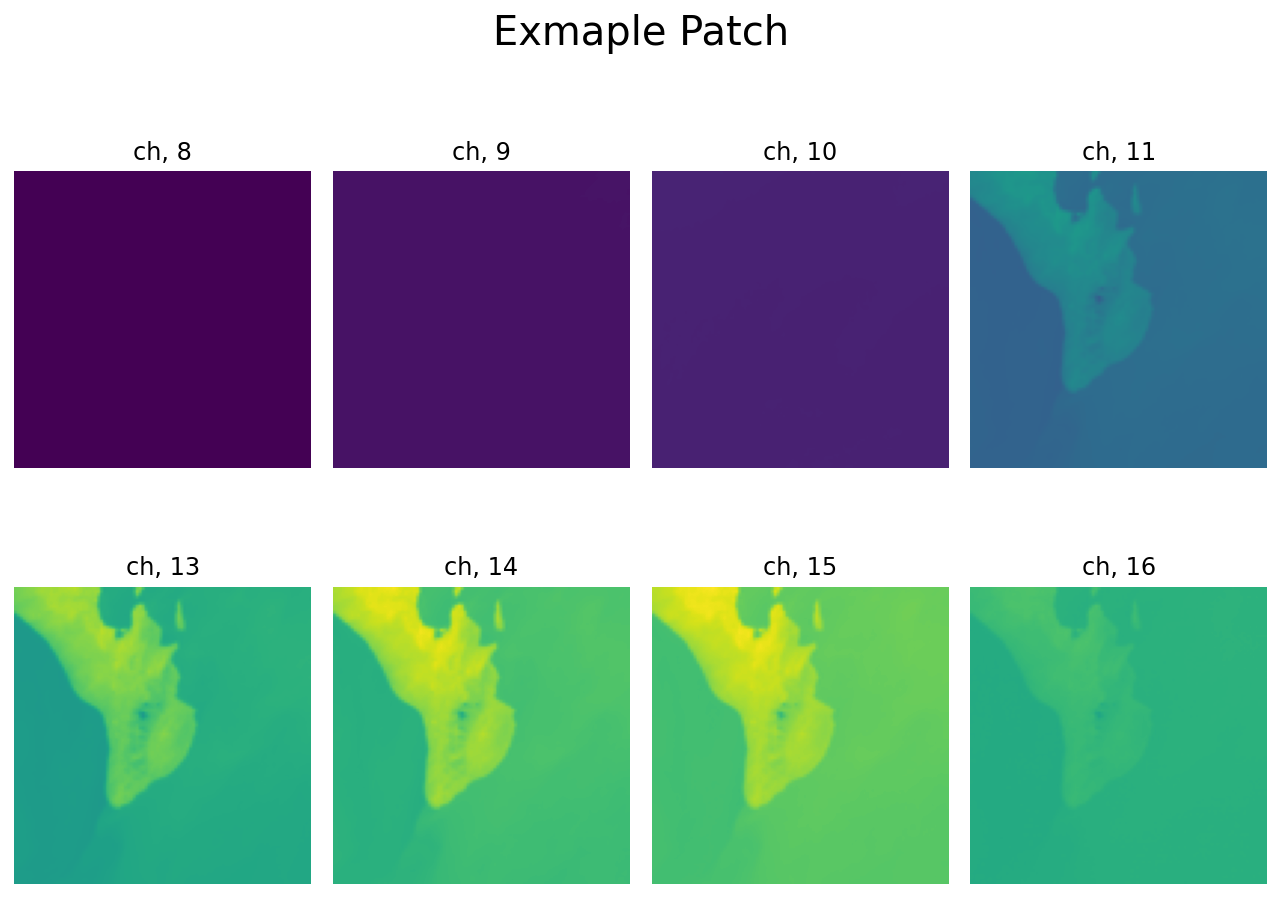

In [7]:
index = 0
vmin = patch[index,:,:,:].min() # set min/max plotting range  
vmax = patch[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(9,7))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    axs[r, i % 4].imshow(patch[index,i,:,:], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[r, i % 4].set_title(f'ch, {str(goes16.bands[i])}')
fig.tight_layout()

In [3]:
# process all of the soundings for the 
sonde_config = {'sonde_profile_dims': 256}
goes_config = {'bands': np.array([8, 9, 10, 11, 13, 14, 15, 16]), 
              'patch_x_length_pixels': 28,
              'patch_y_length_pixels': 28,
              'abi_path': vol + 'goes',
              'time_range_minutes': 5,
              'bt': False}
preprocess.set_configs(sonde_config, goes_config)
preprocess.extract_all_information(vol)

0 Invalid sounding time: 2019-06-24 23:01:00+00:00 lon: -156.780 lat: 71.300
1 Invalid sounding time: 2019-06-25 05:30:00+00:00 lon: -156.780 lat: 71.300
2 Invalid sounding time: 2019-06-25 11:01:00+00:00 lon: -156.780 lat: 71.300
3 Invalid sounding time: 2019-06-25 17:30:00+00:00 lon: -156.780 lat: 71.300
4 Invalid sounding time: 2019-06-24 23:27:00+00:00 lon: -165.430 lat: 64.500
5 Invalid sounding time: 2019-06-24 23:01:00+00:00 lon: -161.800 lat: 60.780
6 Invalid sounding time: 2019-06-25 11:01:00+00:00 lon: -161.800 lat: 60.780
7 Invalid sounding time: 2019-06-24 23:09:00+00:00 lon: -155.620 lat: 62.970
8 Invalid sounding time: 2019-06-24 23:02:00+00:00 lon: -147.870 lat: 64.820
9 Invalid sounding time: 2019-06-25 11:03:00+00:00 lon: -147.870 lat: 64.820
10 Invalid sounding time: 2019-06-24 23:03:00+00:00 lon: -150.020 lat: 61.170
11 Invalid sounding time: 2019-06-25 11:02:00+00:00 lon: -150.020 lat: 61.170
12 Invalid sounding time: 2019-06-24 23:50:00+00:00 lon: -170.220 lat: 57.

In [8]:
xar = xr.open_dataset(vol + '/processed/abi_patches_TEST.nc')

In [11]:
xar.abi.values.shape

(1, 8, 28, 28)

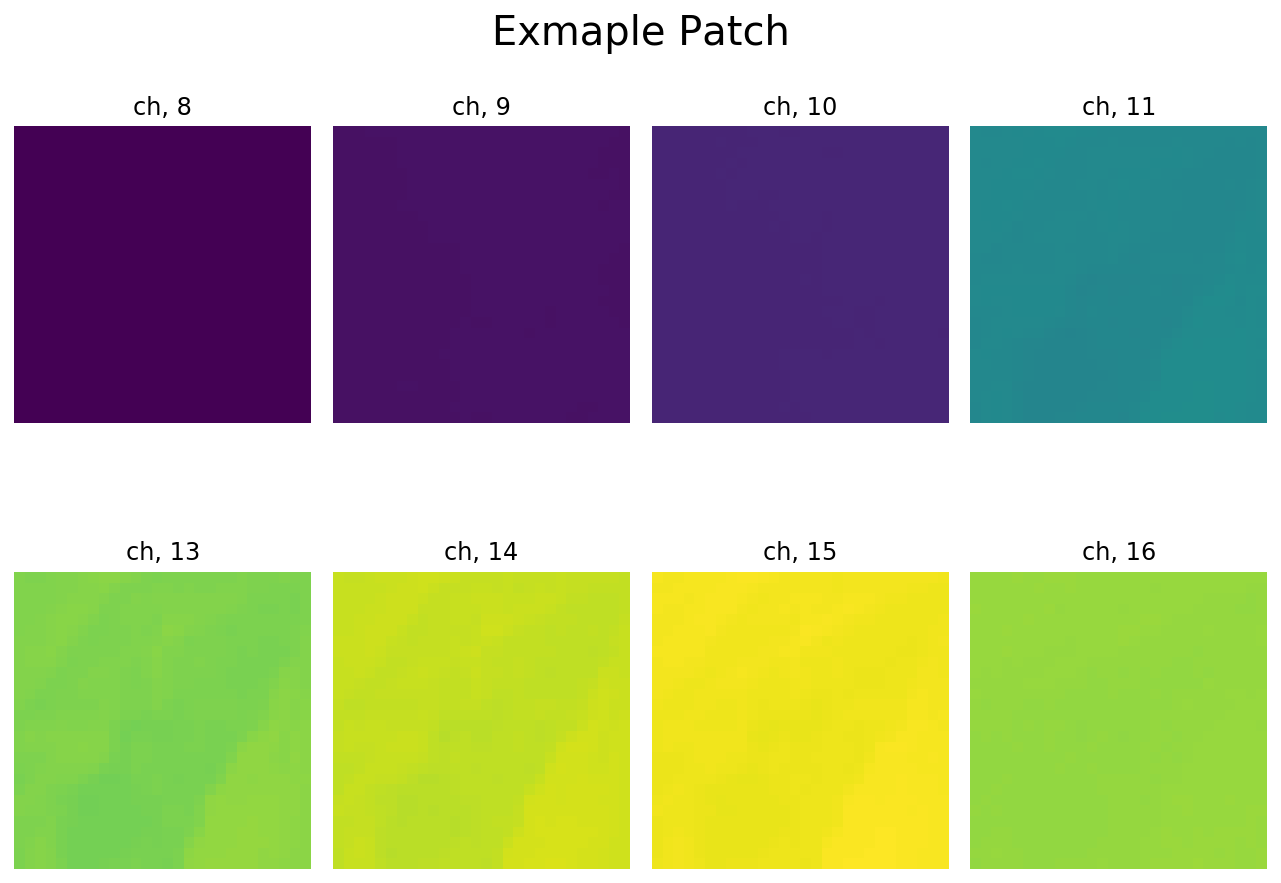

In [4]:
patch = xar.goes_abi.values
index = 1
vmin = patch[index,:,:,:].min() # set min/max plotting range  
vmax = patch[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(9,7))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    axs[r, i % 4].imshow(patch[index,i,:,:], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[r, i % 4].set_title(f'ch, {str(xar.band.values[i])}')
fig.tight_layout()

# Cloud Mask

In [15]:
fin = '/home/stock/clavrx_goes16_2019_175_200022.level2.hdf'
mask = Dataset(fin)

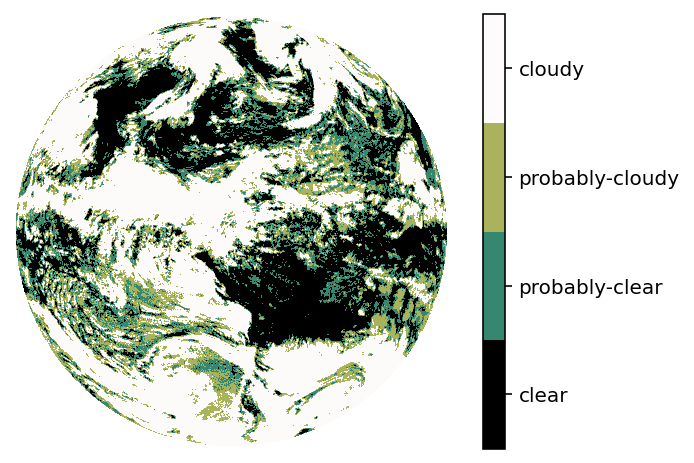

In [163]:
cloud_mask = mask['cloud_mask'][:]

minimum = np.min(cloud_mask)
maximum = np.max(cloud_mask)

cmap = plt.get_cmap('gist_earth', maximum-minimum+1) # Blues_r gist_stern gist_earth
# set limits .5 outside true range
im = plt.imshow(cloud_mask, cmap=cmap, vmin=minimum-.5, vmax=maximum+.5)
#tell the colorbar to tick at integers
cbar = plt.colorbar(im, ticks=np.arange(minimum,maximum+1))
cbar.ax.set_yticklabels(['clear', 'probably-clear', 'probably-cloudy', 'cloudy'])
plt.axis('off');

In [105]:
lat=40.5853
lon=-105.0844
# Compute the abosulte difference between the grid lat/lon and the point
abslat = np.abs(mask['latitude'][:]-lat)
abslon = np.abs(mask['longitude'][:]-lon)

# Element-wise maxima
c = np.maximum(abslon, abslat)

# The index of the minimum maxima (which is the nearest lat/lon)
x, y = np.where(c == np.min(c))
cloud_mask[x[0]][y[0]]

3.0

In [165]:
fin = '/home/stock/clavrx_goes16_2020_222_235619.level2.hdf'
mask = Dataset(fin)

[Text(1, 0.0, 'clear'),
 Text(1, 1.0, 'probably-clear'),
 Text(1, 2.0, 'probably-cloudy'),
 Text(1, 3.0, 'cloudy')]

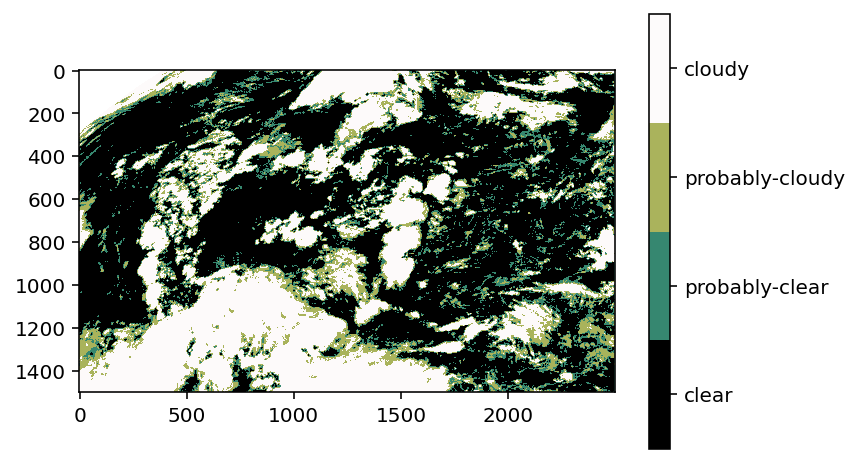

In [174]:
cloud_mask = mask['cloud_mask'][:]

minimum = np.min(cloud_mask)
maximum = np.max(cloud_mask)

cmap = plt.get_cmap('gist_earth', maximum-minimum+1) # Blues_r gist_stern gist_earth
# set limits .5 outside true range
im = plt.imshow(cloud_mask, cmap=cmap, vmin=minimum-.5, vmax=maximum+.5)
#tell the colorbar to tick at integers
cbar = plt.colorbar(im, ticks=np.arange(minimum,maximum+1))
cbar.ax.set_yticklabels(['clear', 'probably-clear', 'probably-cloudy', 'cloudy'])
# plt.axis('off');

# RTMA

In [38]:
fin = vol + 'raobs/arm-sgp/2019/sgpsondewnpnC1.b1.20190624.203400.cdf'
raob = xr.open_dataset(fin)
date = raob.time.values[0]
raob.close()

print(date)

2019-06-24T20:34:00.000000000


In [6]:
raob.site_id

'sgp'

In [104]:
date = pd.Timestamp(1564953860.0, unit='s', tz='UTC')
print(date)

2019-08-04 21:24:20+00:00


In [144]:
center_lon, center_lat = -109.6825, 23.3666
x_size_pixels, y_size_pixels = 100, 100

rtma = rtmaloader.RTMALoader(vol + 'rtma', date, rtma_types=np.array(['LRI']))

patch, lons, lats = rtma.extract_image_patch(center_lon, center_lat, x_size_pixels, y_size_pixels)

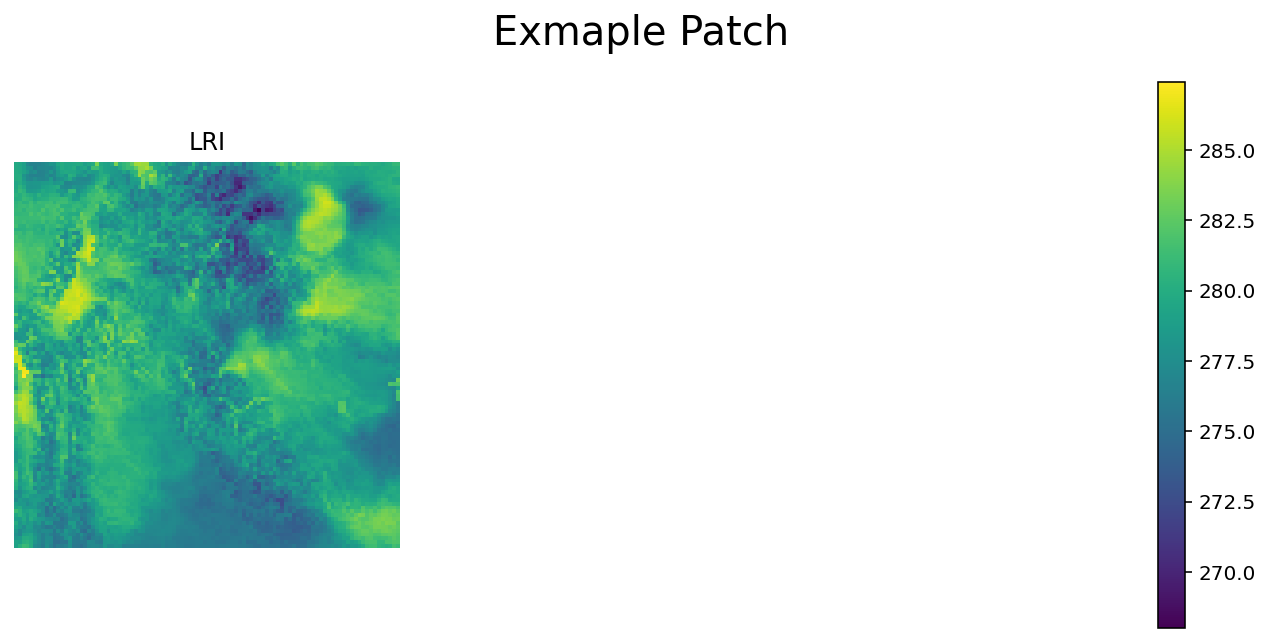

In [143]:
index = 0
vmin = patch[index,:,:,:].min() # set min/max plotting range  
vmax = patch[index,:,:,:].max()

fig, axs = plt.subplots(1, 3, figsize=(9, 4.5))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    im = axs[i].imshow(patch[index,i,:,:], vmin=vmin, vmax=vmax)
    plt.colorbar(im)
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[i].set_title(f'{str(rtma.rtma_types[i])}')
    break
fig.tight_layout()

# NWP RAP

In [7]:
xar = xr.open_dataset(fs[0], decode_times=False)

In [10]:
xar.staLon.values[s], xar.staLat.values[s]

-156.78

In [20]:
s = 20
numMand = xar.numMand.values[s]
numSigT = xar.numSigT.values[s]

ht = np.concatenate([xar.htMan.values[s, :numMand], xar.htSigT.values[s, :numSigT]])
order = ht.argsort()
ht = ht[order]

p = np.concatenate([xar.prMan.values[s, :numMand], xar.prSigT.values[s, :numSigT]])[order]
t = np.concatenate([xar.tpMan.values[s, :numMand], xar.tpSigT.values[s, :numSigT]])[order]
td = t - (np.concatenate([xar.tdMan.values[s, :numMand], xar.tdSigT.values[s, :numSigT]])[order])

pd.to_datetime(xar.relTime.values[s], unit='s'), xar.staLon.values[s], xar.staLat.values[s]

(Timestamp('2019-05-31 23:02:00'), -89.82, 30.33)

In [21]:
ht[:5], t[:5], p[:5]

(array([  8.,  11.,  77., 110., 337.], dtype=float32),
 array([305.4, 306. , 304.1, 303.8, 301.5], dtype=float32),
 array([1011.1, 1011. , 1003.6, 1000. ,  974.9], dtype=float32))

In [28]:
pres = np.zeros((len(locations), 1))
temp = np.zeros((len(locations), 1))
spec = np.zeros((len(locations), 1))
height = np.zeros((len(locations), 1))

lons = np.zeros((len(locations)))
lats = np.zeros((len(locations)))

line = '182:15644474:d=2019053123:HGT:46 hybrid level:anl::lon=270.199032,lat=30.329120,val=23215.4'
line = '201:16825471:d=2019053123:PRES:surface:anl::lon=270.199032,lat=30.329120,val=101150'
line = '201:16825471:d=2019053123:PRES:surface:anl::lon=270.199032,lat=30.329120,val=101150'
items = line.split(':')
if 'ground' in items[4] or 'surface' in items[4]:
    index = 0
else:
    index = int(items[4].split('hybrid level')[0])
print(items, index)
for l, loc in enumerate(items[7:]):

    if lons[l] == 0:
        lons[l] = float(loc[loc.find('lon=') + len('lon='):loc.find('lat=') - 1])
        lats[l] = float(loc[loc.find('lat=') + len('lat='):loc.find('val=') - 1])

    value = float(loc.split('val=')[-1])
    identifier = items[3]

    if identifier == 'PRES':
        pres[l, index] = value
    if identifier == 'HGT':
        height[l, index] = value
    if identifier == 'TMP':
        temp[l, index] = value
    if identifier == 'SPFH':
        spec[l, index] = value

pres, temp, spec, height, lons, lats

['201', '16825471', 'd=2019053123', 'PRES', 'surface', 'anl', '', 'lon=270.199032,lat=30.329120,val=101150'] 0


(array([[101150.],
        [     0.],
        [     0.]]),
 array([[0.],
        [0.],
        [0.]]),
 array([[0.],
        [0.],
        [0.]]),
 array([[0.],
        [0.],
        [0.]]),
 array([270.199032,   0.      ,   0.      ]),
 array([30.32912,  0.     ,  0.     ]))

In [ ]:
201:16825471:d=2019053123:PRES:surface:anl::lon=270.199032,lat=30.329120,val=101150
202:16874388:d=2019053123:HGT:surface:anl::lon=270.199032,lat=30.329120,val=6.85302
203:16997091:d=2019053123:TMP:2 m above ground:anl::lon=270.199032,lat=30.329120,val=305.993
204:17073553:d=2019053123:SPFH:2 m above ground:anl::lon=270.199032,lat=30.329120,val=0.0134189

In [ ]:
1:0:d=2019053123:PRES:1 hybrid level:anl::lon=270.199032,lat=30.329120,val=101055
2:145764:d=2019053123:HGT:1 hybrid level:anl::lon=270.199032,lat=30.329120,val=18.0945
3:269969:d=2019053123:TMP:1 hybrid level:anl::lon=270.199032,lat=30.329120,val=305.686
4:342156:d=2019053123:SPFH:1 hybrid level:anl::lon=270.199032,lat=30.329120,val=0.0129926

In [3]:
from os.path import exists, join
d = 20190601
fs = glob.glob(join("/mnt/mlnas01/mlsoundings/raobs/noaa-esrl", '*', f"*{d}*"))

def _group_by_times(inds, rel_times):
    """Group radiosondes by release time rounded by day+hour."""
    timestamps = pd.to_datetime(rel_times[inds], unit='s')
    print(timestamps)
    rounded_timestamps = timestamps.round('H')
    days = rounded_timestamps.day.values
    hours = rounded_timestamps.hour.values

    groups = []
    for day in np.unique(days):
        for hour in np.unique(hours):
            group_mask = np.logical_and.reduce([rounded_timestamps.day.values == day, 
                                                rounded_timestamps.hour.values == hour])
            if group_mask.any():
                groups.append(inds[group_mask])
    return groups


def set_noaa_profile(xar, path, s):
    numMand = xar.numMand.values[s]
    numSigT = xar.numSigT.values[s]

    ht = np.concatenate([xar.htMan.values[s, :numMand], xar.htSigT.values[s, :numSigT]])
    order = ht.argsort()
    ht = ht[order]

    p = np.concatenate([xar.prMan.values[s, :numMand], xar.prSigT.values[s, :numSigT]])[order]
    t = np.concatenate([xar.tpMan.values[s, :numMand], xar.tpSigT.values[s, :numSigT]])[order]
    td = t - (np.concatenate([xar.tdMan.values[s, :numMand], xar.tdSigT.values[s, :numSigT]])[order])
    t -= 273.15
    td -= 273.15
    
    altitude_intervals = np.linspace(
        ht[0], config['raob']['alt_el'], config['raob']['profile_dims'])

    dataset.sonde_pres = interpolate_to_height_intervals(ht, p, altitude_intervals)
    dataset.sonde_tdry = interpolate_to_height_intervals(ht, t, altitude_intervals)
    dataset.sonde_dp   = interpolate_to_height_intervals(ht, td, altitude_intervals)
    dataset.sonde_alt  = altitude_intervals

    dataset.sonde_file = path
    dataset.sonde_site_id = xar.staName.values[s]

for f in fs:
    xar = xr.open_dataset(f, decode_times=False)
    rel_times = xar.relTime.values
    # should the mask look at other values? e.g., top-sfc > 15,000?
    inds = xar.recNum.values[rel_times != 99999]
    
    groups = _group_by_times(inds, rel_times)
                
    for group in groups:
        locations = list(zip(xar.staLon.values[group], xar.staLat.values[group]))
        date = pd.Timestamp(rel_times[group[0]], unit='s', tz='UTC')

        rap = raploader.RAPLoader('/mnt/mlnas01/grasso/cira', date)
        wgrib2 = '/home/stock/bin/grib2/wgrib2/wgrib2'

        start_t = time.time()
        pres, temp, spec, height, lons, lats = rap.extract_rap_profile(locations, wgrib2)
        print(f'{len(locations)} locations finished in {time.time() - start_t} s')
    
        for s in group:
            # create new dataset
            # set_noaa_profile(xar, s)
            # set goes
            # set rtma
            # set rap
            pass
    
    xar.close()

DatetimeIndex(['2019-05-31 23:01:00', '2019-05-31 23:06:00',
               '2019-05-31 23:12:00', '2019-05-31 23:01:00',
               '2019-05-31 23:03:00', '2019-05-31 23:02:00',
               '2019-05-31 23:03:00', '2019-05-31 23:01:00',
               '2019-05-31 23:21:00', '2019-05-31 23:01:00',
               ...
               '2019-06-01 11:07:00', '2019-06-01 11:21:00',
               '2019-06-01 11:25:00', '2019-06-01 11:06:00',
               '2019-06-01 11:02:00', '2019-06-01 11:50:00',
               '2019-06-01 11:04:00', '2019-06-01 17:30:00',
               '2019-06-01 17:00:00', '2019-06-01 19:01:00'],
              dtype='datetime64[ns]', length=174, freq=None)


KeyboardInterrupt: 

In [8]:
date = pd.Timestamp('2019-09-12T12:34:00.000000000', tz='UTC')

rap = raploader.RAPLoader('/mnt/mlnas01/grasso/cira', date)
wgrib2 = '/home/stock/bin/grib2/wgrib2/wgrib2'

center_lon, center_lat = -109.6825, 23.3666
locations = [(center_lon, center_lat)]

start_t = time.time()
pres, temp, spec, height, lons, lats = rap.extract_rap_profile(locations, wgrib2)
print(f'Finished in {time.time() - start_t} s')

Finished in 8.318092823028564 s


In [10]:
pres.shape, temp.shape, spec.shape, height.shape, lons.shape, lats.shape

((1, 50), (1, 50), (1, 50), (1, 50), (1, 1), (1, 1))

In [56]:
a = """198:17345054:d=2019091213:HGT:50 hybrid level:anl::lon=250.949615,lat=23.054507,val=29648.5:lon=999,lat=999,val=9.999e+20
-lon: grid outside of domain of data
199:17389396:d=2019091213:TMP:50 hybrid level:anl::lon=250.949615,lat=23.054507,val=224.107:lon=999,lat=999,val=9.999e+20
-lon: grid outside of domain of data
200:17420004:d=2019091213:SPFH:50 hybrid level:anl::lon=250.949615,lat=23.054507,val=3.1147e-06:lon=999,lat=999,val=9.999e+20""".split("\n")

for line in a:
    if 'grid outside of domain of data' in line:
        continue
    items = line.split(':')
    print(items)
    index = int(items[4].split('hybrid level')[0]) - 1
    value = float(items[-1].split('val=')[-1])

['198', '17345054', 'd=2019091213', 'HGT', '50 hybrid level', 'anl', '', 'lon=250.949615,lat=23.054507,val=29648.5', 'lon=999,lat=999,val=9.999e+20']
['199', '17389396', 'd=2019091213', 'TMP', '50 hybrid level', 'anl', '', 'lon=250.949615,lat=23.054507,val=224.107', 'lon=999,lat=999,val=9.999e+20']
['200', '17420004', 'd=2019091213', 'SPFH', '50 hybrid level', 'anl', '', 'lon=250.949615,lat=23.054507,val=3.1147e-06', 'lon=999,lat=999,val=9.999e+20']


In [43]:
pres.shape, temp.shape, spec.shape, height.shape, lon, lat

((50,), (50,), (50,), (50,), 250.380746, 23.36632)

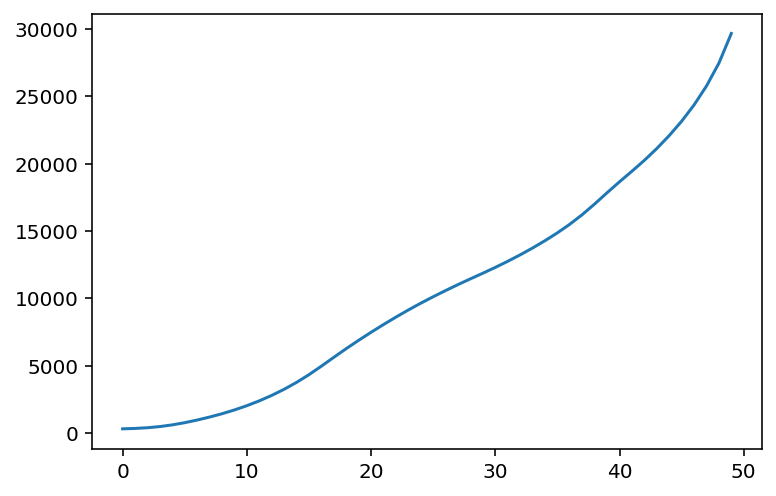

In [12]:
plt.plot(height[0])

# Preprocessor

In [178]:
# process all of the soundings for the 
preprocess.main('/home/stock/research/cira-ml-soundings/soundings/preprocessing/config.yaml')

noaa
3 locations finished in 8.170017719268799 s
ERROR: lch noaa-esrl-2019060100-raob.cdf, No LPI RTMA files within 60 minutes of 2019-06-01 00:13:00. Nearest file is within 167.000 minutes
/mnt/data1/stock/mlsoundings/processed/shv_2019_05_31_2350.nc
/mnt/data1/stock/mlsoundings/processed/chh_2019_05_31_2339.nc
1 locations finished in 8.300350904464722 s
ERROR: brw noaa-esrl-2019060100-raob.cdf, [RTMA] lon -156.77999877929688 and lat 71.30000305175781 out of range
80 locations finished in 8.291172981262207 s
ERROR: brw noaa-esrl-2019060100-raob.cdf, [RTMA] lon -156.77999877929688 and lat 71.30000305175781 out of range
ERROR: bet noaa-esrl-2019060100-raob.cdf, [RTMA] lon -161.8000030517578 and lat 60.779998779296875 out of range
ERROR: mcg noaa-esrl-2019060100-raob.cdf, [RTMA] lon -155.6199951171875 and lat 62.970001220703125 out of range
ERROR: fai noaa-esrl-2019060100-raob.cdf, [RTMA] lon -147.8699951171875 and lat 64.81999969482422 out of range
ERROR: anc noaa-esrl-2019060100-raob.c

ERROR: adq noaa-esrl-2019060100-raob.cdf, [RTMA] lon -152.47999572753906 and lat 57.75 out of range
ERROR: yak noaa-esrl-2019060100-raob.cdf, [RTMA] lon -139.6699981689453 and lat 59.52000045776367 out of range
ERROR: ann noaa-esrl-2019060100-raob.cdf, [RTMA] lon -131.57000732421875 and lat 55.029998779296875 out of range
/mnt/data1/stock/mlsoundings/processed/eyw_2019_05_31_2320.nc
/mnt/data1/stock/mlsoundings/processed/mfl_2019_05_31_2306.nc
/mnt/data1/stock/mlsoundings/processed/jax_2019_05_31_2307.nc
/mnt/data1/stock/mlsoundings/processed/tbw_2019_05_31_2303.nc
/mnt/data1/stock/mlsoundings/processed/tlh_2019_05_31_2304.nc
/mnt/data1/stock/mlsoundings/processed/ffc_2019_05_31_2316.nc
/mnt/data1/stock/mlsoundings/processed/bmx_2019_05_31_2301.nc
/mnt/data1/stock/mlsoundings/processed/sil_2019_05_31_2302.nc
/mnt/data1/stock/mlsoundings/processed/jan_2019_05_31_2303.nc
/mnt/data1/stock/mlsoundings/processed/fwd_2019_05_31_2311.nc
/mnt/data1/stock/mlsoundings/processed/bro_2019_05_31_23

In [156]:
# xar = xr.open_dataset('/mnt/data1/stock/mlsoundings/processed/shv_2019_05_31_2350.nc')
# xar = xr.open_dataset('/mnt/data1/stock/mlsoundings/processed/chh_2019_05_31_2339.nc')
xar = xr.open_dataset('/mnt/data1/stock/mlsoundings/processed/sgp_2020_01_02_0533.nc')
xar

<xarray.Dataset>
Dimensions:         (band: 8, goes_x: 3, goes_y: 3, nwp_dims: 50, profile_dims: 256, rtma_type: 3, rtma_x: 3, rtma_y: 3)
Coordinates:
  * goes_y          (goes_y) int64 0 1 2
  * goes_x          (goes_x) int64 0 1 2
  * band            (band) int64 8 9 10 11 13 14 15 16
  * rtma_y          (rtma_y) int64 0 1 2
  * rtma_x          (rtma_x) int64 0 1 2
  * rtma_type       (rtma_type) object 'LPI' 'LRI' 'LTI'
  * profile_dims    (profile_dims) int64 0 1 2 3 4 5 ... 250 251 252 253 254 255
  * nwp_dims        (nwp_dims) int64 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
Data variables:
    sonde_rel_time  datetime64[ns] ...
    sonde_file      object ...
    sonde_pres      (profile_dims) float64 ...
    sonde_tdry      (profile_dims) float64 ...
    sonde_dp        (profile_dims) float64 ...
    sonde_alt       (profile_dims) float64 ...
    nwp_file        object ...
    nwp_lon         object ...
    nwp_lat         object ...
    nwp_pres        (nwp_dims) float64 ...
    nwp_tdry        (nwp_dims) float64 ...
    nwp_spfm        (nwp_dims) float64 ...
    nwp_alt         (nwp_dims) float64 ...
    goes_files      (band) object ...
    goes_abi        (band, goes_y, goes_x) float32 ...
    goes_lon        (goes_y, goes_x) float64 ...
    goes_lat        (goes_y, goes_x) float64 ...
    rtma_files      (rtma_type) object ...
    rtma_values     (rtma_type, rtma_y, rtma_x) float32 ...
    rtma_lon        (rtma_y, rtma_x) float64 ...
    rtma_lat        (rtma_y, rtma_x) float64 ...

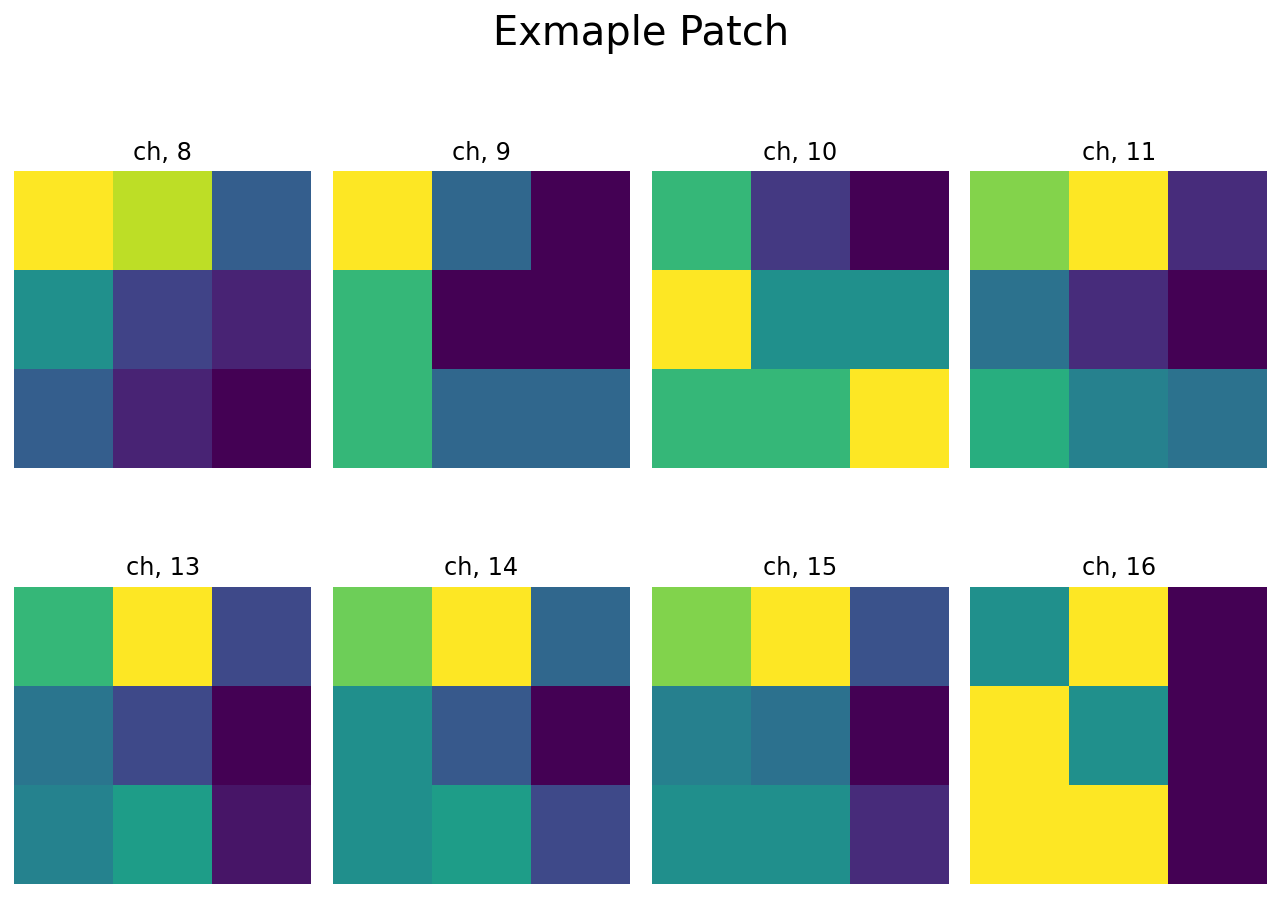

In [177]:
patch = xar.goes_abi.values

fig, axs = plt.subplots(2, 4, figsize=(9,7))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    axs[r, i % 4].imshow(patch[i,:,:])
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[r, i % 4].set_title(f'ch, {str(xar.band.values[i])}')
fig.tight_layout()

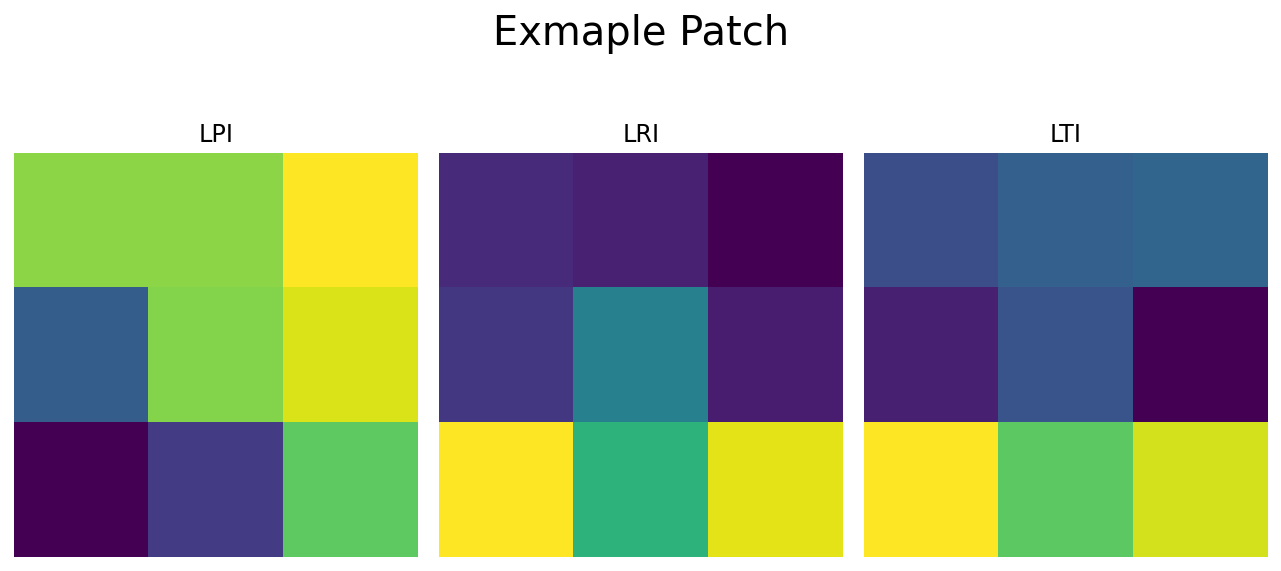

In [176]:
patch = xar.rtma_values.values
fig, axs = plt.subplots(1, 3, figsize=(9, 4.5))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    axs[i].imshow(patch[i])
    plt.suptitle('Exmaple Patch', fontsize=20)
    axs[i].set_title(f'{str(xar.rtma_type.values[i])}')
fig.tight_layout()

---
# Misc

In [55]:
sounding_dict = dict()
sounding_dict[radiosonde_utils.PRESSURE_COLUMN_KEY] = xar.sonde_profile_P.values[index]
sounding_dict[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = xar.sonde_profile_T.values[index]
sounding_dict[radiosonde_utils.DEWPOINT_COLUMN_KEY] = xar.sonde_profile_Td.values[index]

In [66]:
radiosonde_products.surface_based_cape_cin(sounding_dict)

(2023.905889349416, -101.55760642758013)

In [60]:
radiosonde_products.most_unstable_cape_cin(sounding_dict)

(2571.6940645766363, -11.010678054471661)

In [83]:
import metpy.calc

el_pressures, el_temperatures = 0, 0
n = 0

for i in xar.sample.values:
    sounding_dict = dict()
    sounding_dict[radiosonde_utils.PRESSURE_COLUMN_KEY] = xar.sonde_profile_P.values[i]
    sounding_dict[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = xar.sonde_profile_T.values[i]
    sounding_dict[radiosonde_utils.DEWPOINT_COLUMN_KEY] = xar.sonde_profile_Td.values[i]
    el_pressure, el_temperature = radiosonde_products.el(sounding_dict)
    
    if not np.isnan(el_pressure):
        el_pressures += el_pressure
        el_temperatures += el_temperature
        n += 1.
        
print(el_pressures/n, el_temperature/n)

380.8878119529115 nan


moist lapse rate in pressure coordinates
$$\frac{dT}{dP} = \Big(\frac{1}{P}\Big) \frac{R_d T + L_v r_s}{C_{pd} + \frac{L_v^2 r_s \epsilon}{R_d T^2}} : b = 1$$

dry lapse rate in pressure coordinates
$$\frac{dT}{dP} = \frac{b R_d T}{C_{pd} P}$$

(100, 2) (100, 1) (2, 1)


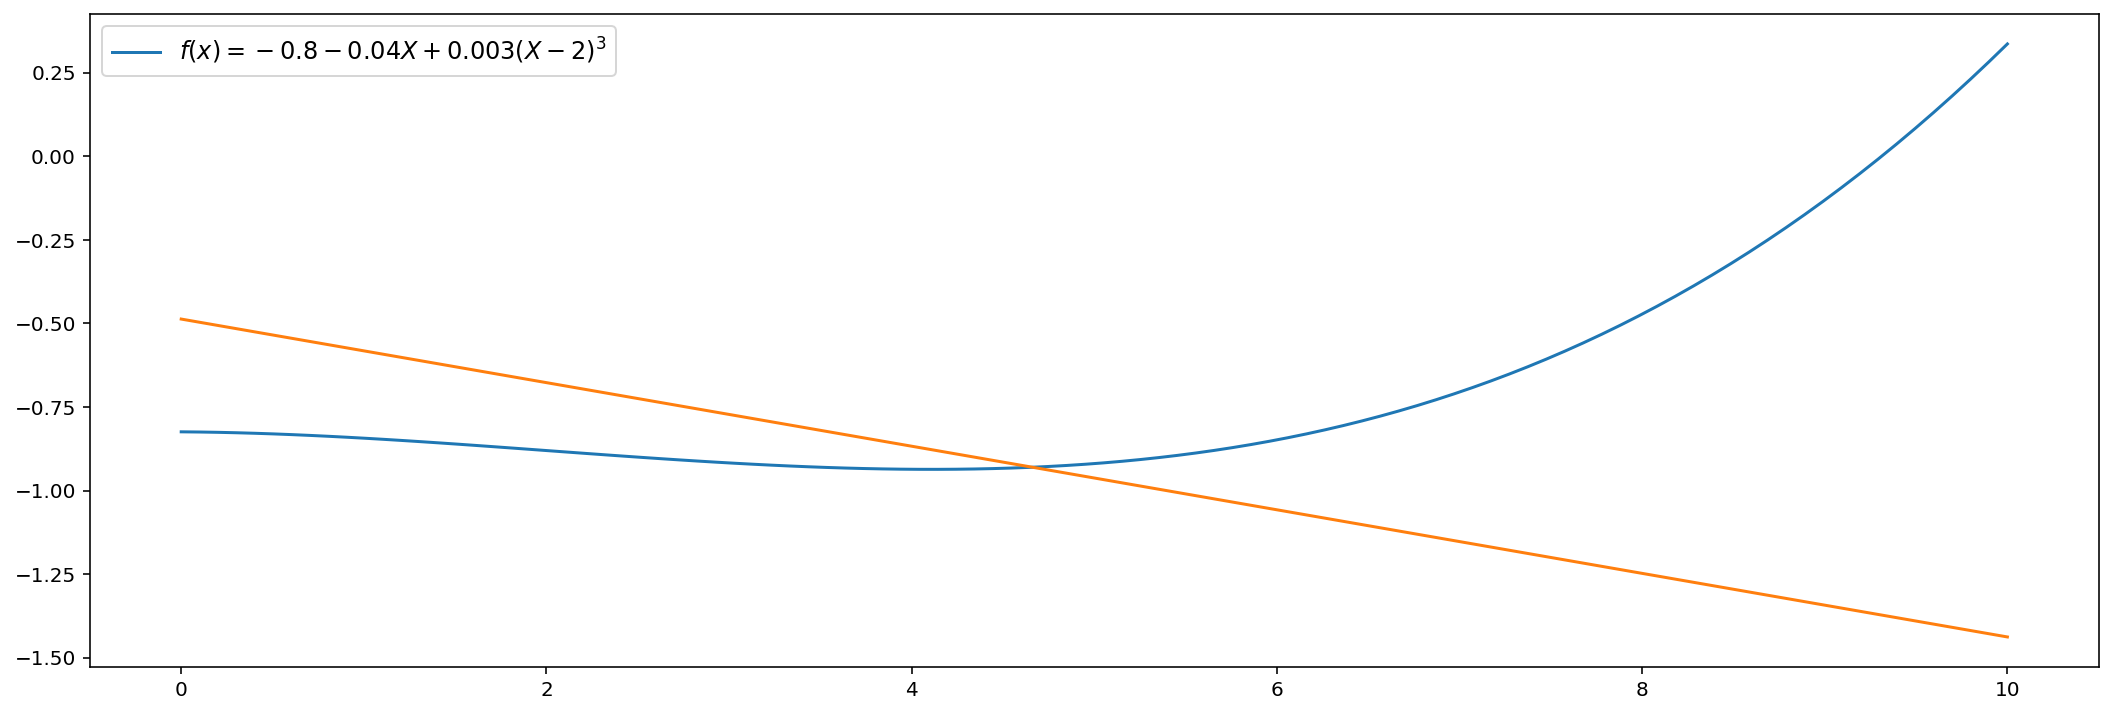

In [82]:
n_samples = 100
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = -0.8 - 0.04 * X  + 0.003 * (X - 2)**3
X = np.insert( X, 0, 1, axis=1 )
w = np.random.uniform(-1, 1, (X.shape[1], 1 ))
print(X.shape, T.shape, w.shape)

plt.figure(figsize=(18, 6))
plt.plot(X[:,1], T, label="$f(x) = -0.8 - 0.04 X + 0.003 (X - 2)^3$")
plt.plot(X[:,1], X @ w)
plt.legend(loc='best', fontsize=12);

# CAPE/CIN Calculations

In [8]:
from soundings.experiments import results as results_calc
from soundings.plotting import radiosonde_plotting

In [3]:
f = '/mnt/data1/stock/mlsoundings/preprocessed.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?

In [123]:
container.close()

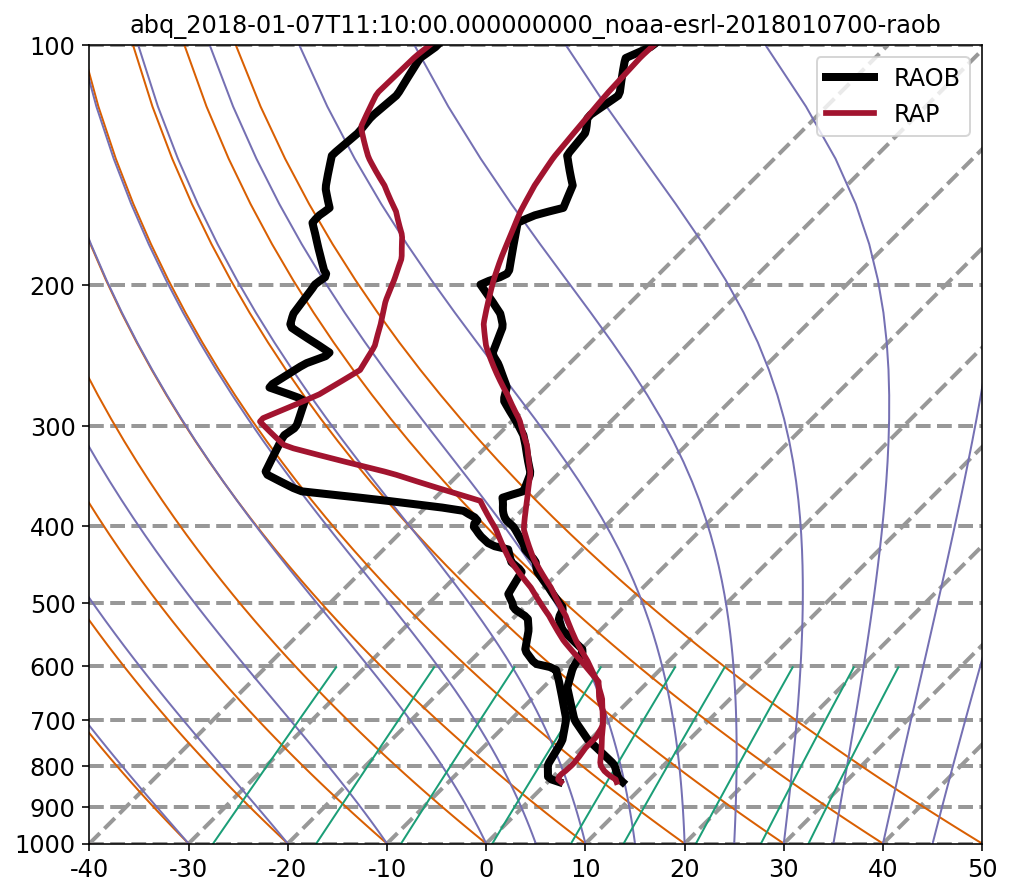

In [97]:
index = 12
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = rap[index,:,dl.TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = rap[index,:,dl.DEWPOINT]

title = sonde_files[index]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");

In [124]:
a = np.zeros((len(raob), 2))
a[0, 0] = 5
a[0, 1] = np.nan
a

array([[ 5., nan],
       [ 0.,  0.],
       [ 0.,  0.],
       ...,
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [129]:
b = np.load('/mnt/data1/stock/mlsoundings/cape_cin.npy')

In [131]:
b[:100]

array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [ 14.66274891,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
 

In [109]:
capes = np.zeros(len(raob))
cins = np.zeros(len(raob))

f = FloatProgress(min=0, max=len(raob))
display(f)

for i in range(len(raob)):
    pressure = raob[i, :, dl.PRESSURE]
    temperature = raob[i, :, dl.TEMPERATURE]
    dewpoint = raob[i, :, dl.DEWPOINT]
    cape, cin = results_calc.compute_cape_cin(pressure, temperature, dewpoint)
    capes[i] = cape
    cins[i] = cin
    
    f.value += 1

FloatProgress(value=0.0, max=81103.0)

ValueError: The values in t must be monotonically increasing or monotonically decreasing; repeated values are allowed.